# Historical Weather API
* Is a flexible publicly available API help us track weather changes from 1940
* We have chosen France as our country to Study
* We will conduct all the needed EDA in this notebook

In [53]:
!pip -q install openmeteo-requests
!pip -q install requests-cache retry-requests numpy pandas

## Getting dataframe via code snippet provided in the API website
Temp Values for period of 4 years, from 01/01/2020 00h au 31/12/2023 23h. Timezones are dealt by setting the paramater
to auto, the python script retrives the data
* FRANCE has the following cordinates : Laltitude :46 and Longtitude : 2
* Time zone is set to Auto

In [54]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

def get_data(begin_date="2020-01-01", end_date="2023-12-31"):
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)
    
    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": 46,
        "longitude": 2,
        "start_date": {begin_date},
        "end_date": {end_date},
        "hourly": "temperature_2m",
        "timezone": "auto"
    }
    responses = openmeteo.weather_api(url, params=params)
    
    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")
    
    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    
    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}
    hourly_data["temperature_2m"] = hourly_temperature_2m
    
    ts_data= pd.DataFrame(data = hourly_data)
    return ts_data

ts_data =  get_data()

Coordinates 46.01054382324219°N 2.0°E
Elevation 550.0 m asl
Timezone b'Europe/Paris' b'CEST'
Timezone difference to GMT+0 7200 s


In [55]:
ts_data.head()

,date,temperature_2m
0,2019-12-31 22:00:00+00:00,1.263
1,2019-12-31 23:00:00+00:00,1.913
2,2020-01-01 00:00:00+00:00,2.163
3,2020-01-01 01:00:00+00:00,1.913
4,2020-01-01 02:00:00+00:00,1.863


## Checking for Null Values and dropping them in case they exist

In [56]:
print('data colmns are : ',ts_data.columns)
ts_data.isna().sum()
ts_data.dropna(inplace=True)

data colmns are :  Index(['date', 'temperature_2m'], dtype='object')


### Converting the date column to date

In [57]:
ts_data["date"] = pd.to_datetime(ts_data["date"])
ts_data.dtypes

date              datetime64[ns, UTC]
temperature_2m                float32
dtype: object

### Our target
#### Is Prediction of Temp (Numeric Var) in France for a day with step of time equals to 3h : 00h, 03h, 06h, …, 21h.


In [58]:
ts_data.describe()

,temperature_2m
count,35064.000000
mean,11.246671
std,7.227768
min,-8.187000
25%,6.013000
50%,10.912999
75%,16.213001
max,35.763000


## Imports

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [60]:
ts_data.shape

(35064, 2)

In [61]:
ts_data = ts_data.set_index('date')

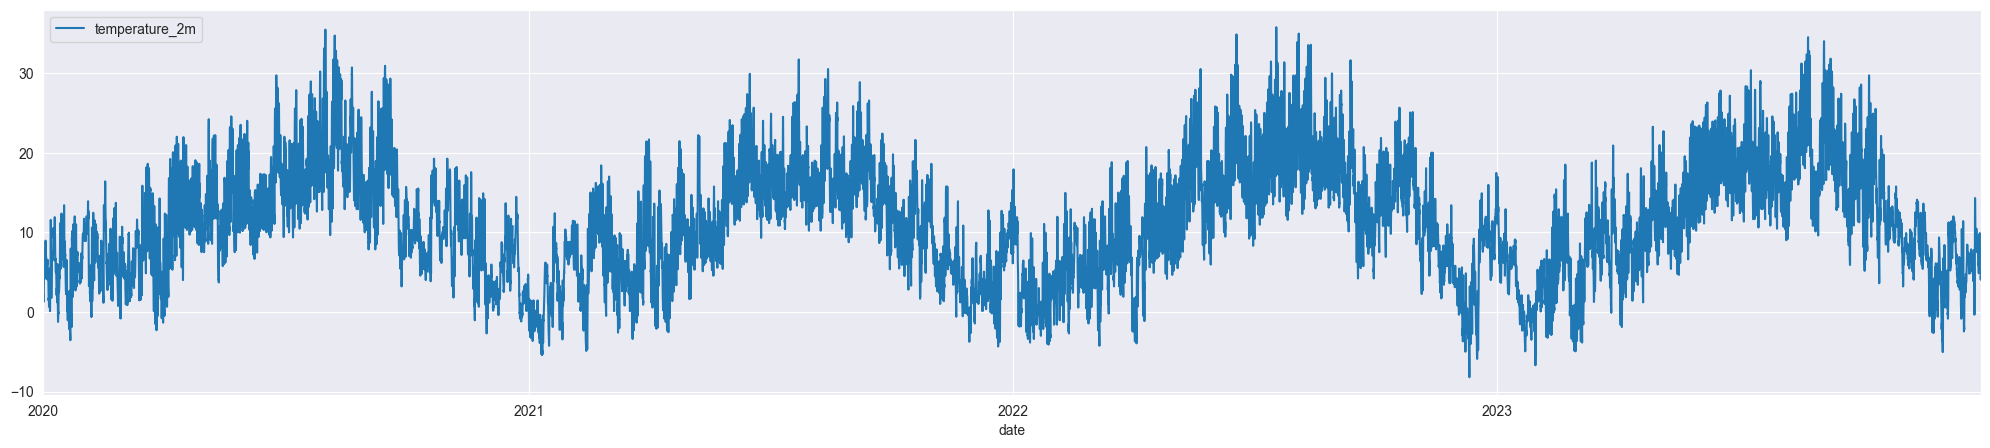

In [62]:
ts_data.plot(figsize=(25,5));

### New dataframe where each value is the mean of every 3 consecutive hours from the original dataframe.

In [63]:
# we Resampled the dataframe with a frequency of 3 hours, and calculate the mean
ts_data = ts_data.resample('3H').mean()
ts_data

,temperature_2m
date,
2019-12-31 21:00:00+00:00,1.588000
2020-01-01 00:00:00+00:00,1.979667
2020-01-01 03:00:00+00:00,1.513000
2020-01-01 06:00:00+00:00,2.746333
2020-01-01 09:00:00+00:00,5.579667
...,...
2023-12-31 09:00:00+00:00,6.129667
2023-12-31 12:00:00+00:00,5.563000
2023-12-31 15:00:00+00:00,4.796333


### Removing 2019 rows

In [64]:
# Filter rows where the year is not 2019
ts_data = ts_data[ts_data.index.year != 2019]
ts_data

,temperature_2m
date,
2020-01-01 00:00:00+00:00,1.979667
2020-01-01 03:00:00+00:00,1.513000
2020-01-01 06:00:00+00:00,2.746333
2020-01-01 09:00:00+00:00,5.579667
2020-01-01 12:00:00+00:00,6.913000
...,...
2023-12-31 09:00:00+00:00,6.129667
2023-12-31 12:00:00+00:00,5.563000
2023-12-31 15:00:00+00:00,4.796333


### Checking if the Dataset is stationary or not using ADF Test

In [65]:
!pip install -q stattools

In [66]:
from statsmodels.tsa.stattools import adfuller

adftest = adfuller(ts_data['temperature_2m'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -5.195973996936072
P-Value: 8.912675420400373e-05
Number of lags: 40
Number of observations: 11647
Critical Values: {'1%': -3.9595474999389686, '5%': -3.4108670220792123, '10%': -3.1272720260291607}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


### Features Engneering EDA

#### Exploring Trend on Yearly and Monthly Bases

In [67]:
viz_ts_data = ts_data.copy()
viz_ts_data['year'] = [d.year for d in viz_ts_data.index]
viz_ts_data['month'] = [d.strftime('%b') for d in viz_ts_data.index]
years = viz_ts_data['year'].unique()

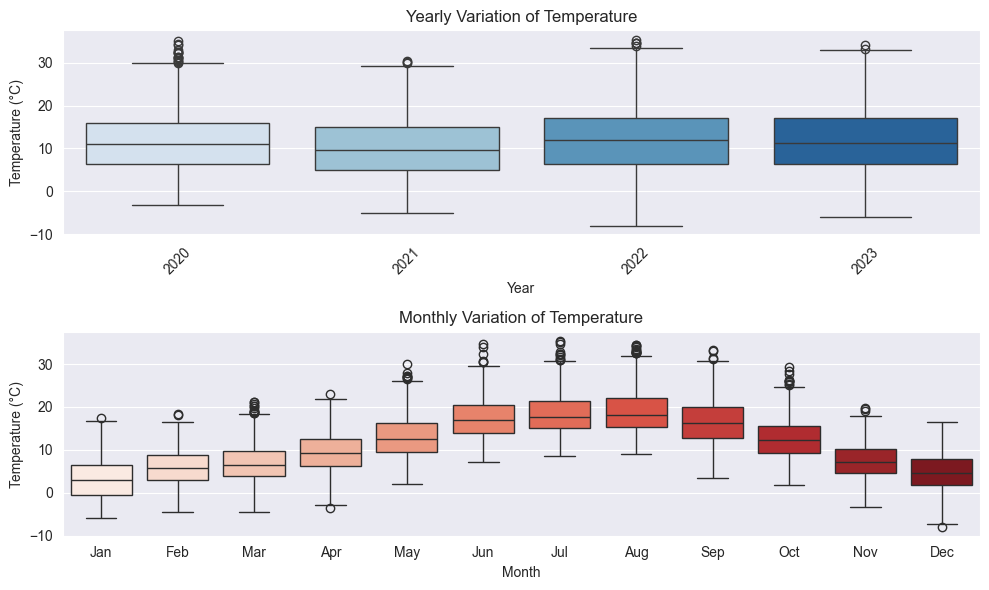

In [68]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)  # Create subplot
sns.boxplot(data=viz_ts_data, x='year', y='temperature_2m', palette='Blues')
plt.title('Yearly Variation of Temperature')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)

# Plot boxplot for monthly temperature variation
plt.subplot(2, 1, 2)  # Create subplot
sns.boxplot(data=viz_ts_data, x='month', y='temperature_2m', order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], palette='Reds')  # Add order for x-axis categories and palette for color
plt.title('Monthly Variation of Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.show()

#### Comments
* ***Trend goes up and potentially gets higher We notice 2020 and 2022 have also outliers***
* ***Trend (Temp) gets higher starting from (spring season) Mars May Jun July August October (noticing also outliers) starts going down (near winter)***

## Components of a time series

In [69]:
!pip -q install statsmodels

#### We will use seasonal_decompose methode we will pass the target and we will use model additive implies
##### Value = Base Level + Trend + Seasonality + Error

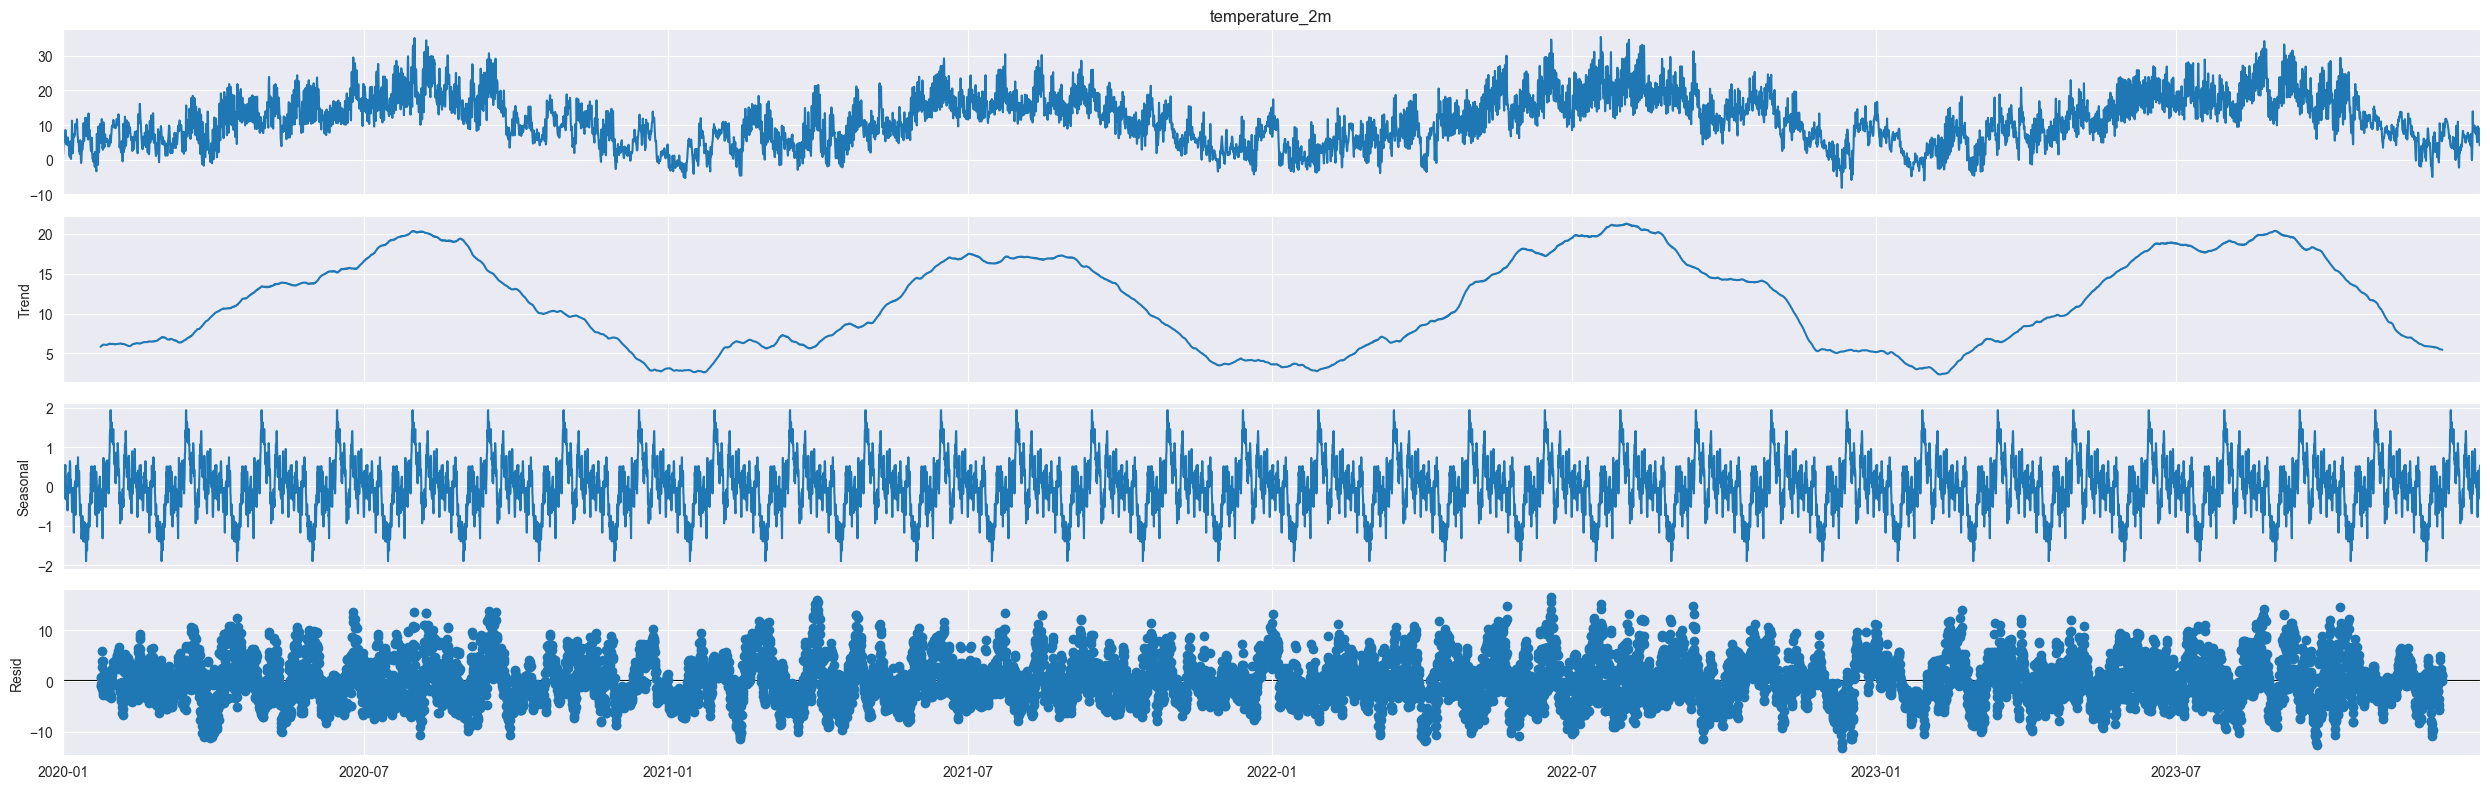

In [70]:
from statsmodels.api import tsa

# Get Trend, Seasonal, and Residuals components
res = tsa.seasonal_decompose(ts_data['temperature_2m'], model='additive',period=365)
trend = res.trend
seasonal = res.seasonal
residuals = res.resid
plt.rc("figure", figsize=(25,8))
resplot = res.plot()

### AutoCorrelation plot from pandas
***In this step we wanted to know how the lags that are positivly fort colorrated the ones above y=0***

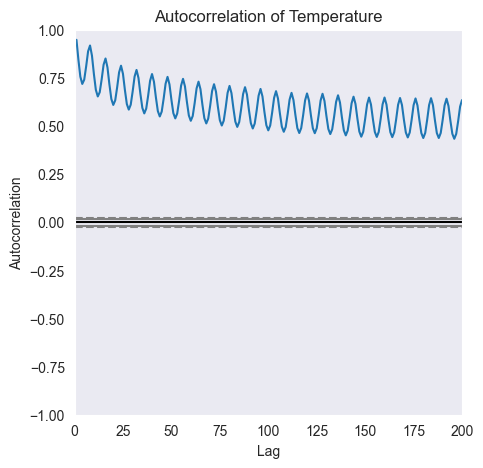

In [71]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(5, 5))
ax = autocorrelation_plot(ts_data.temperature_2m)
# Customize plot attributes
ax.set_title('Autocorrelation of Temperature')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_xlim(0, 200)
plt.show()

### From the plot we can see that the lag in range(1, 20) is fortly positive colerrated above
**Range(0,50) of lags is also has signivigative corrolatoin**

## ARIMA, SARIMA et SARIMAX
***ARIMA Exprimentation***

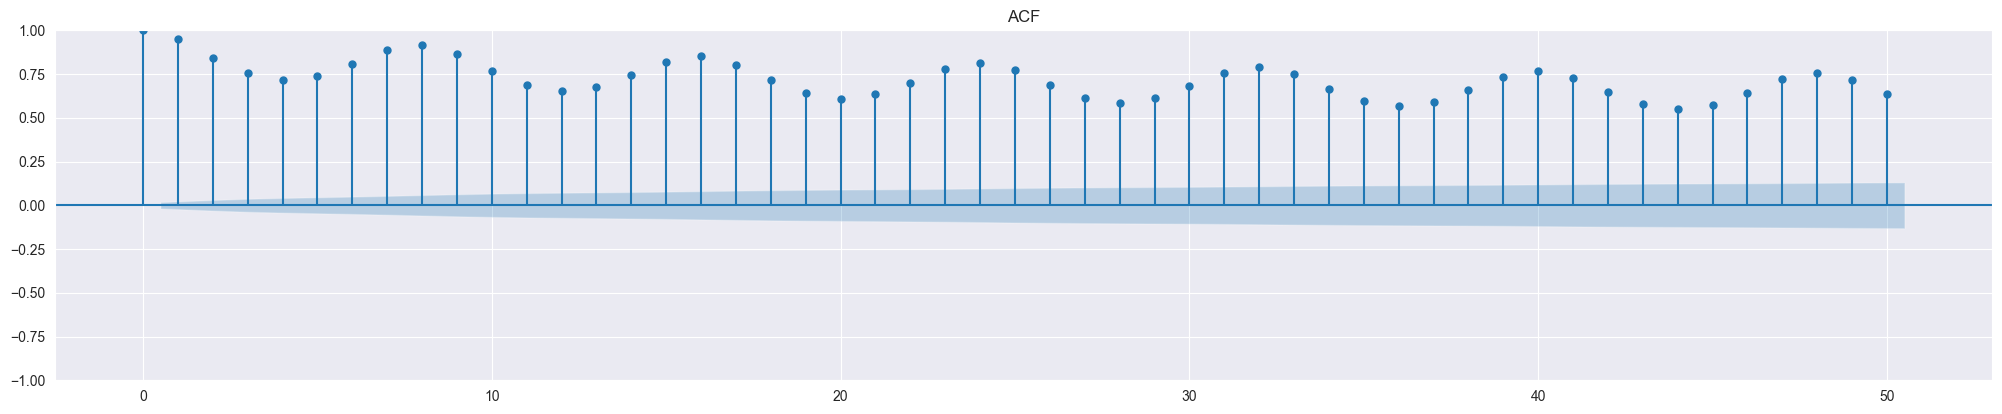

In [72]:
import statsmodels.graphics.tsaplots as tsaplots

fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(ts_data, lags=50, ax=ax1, title="ACF");

### PACF

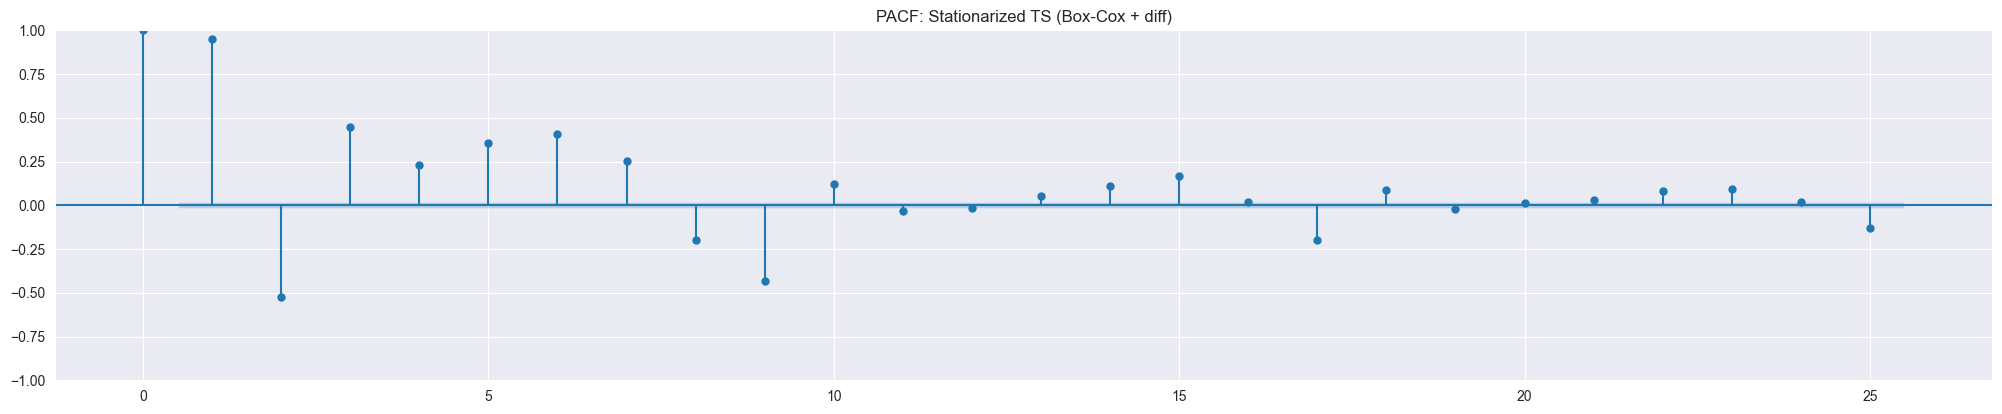

In [73]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_pacf(ts_data, lags=25, ax=ax1, title="PACF: Stationarized TS (Box-Cox + diff)")

In [74]:
from statsmodels.tsa.arima.model import ARIMA

# p,d,q
order=(3,1,3)

model = ARIMA(ts_data, order=order).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:         temperature_2m   No. Observations:                11688
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -20807.107
Date:                Mon, 08 Apr 2024   AIC                          41628.213
Time:                        08:34:06   BIC                          41679.777
Sample:                    01-01-2020   HQIC                         41645.533
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4169      0.003    139.889      0.000       0.411       0.423
ar.L2          0.4081      0.004    101.838      0.000       0.400       0.416
ar.L3         -0.9907      0.003   -338.756      0.0

In [75]:
# Split data into train (80%) and test (20%) sets
ind_split = int(len(ts_data) * 0.8)

ts_train = ts_data[:ind_split]
ts_test = ts_data[ind_split:]

ts_data.shape, ts_train.shape, ts_test.shape

((11688, 1), (9350, 1), (2338, 1))

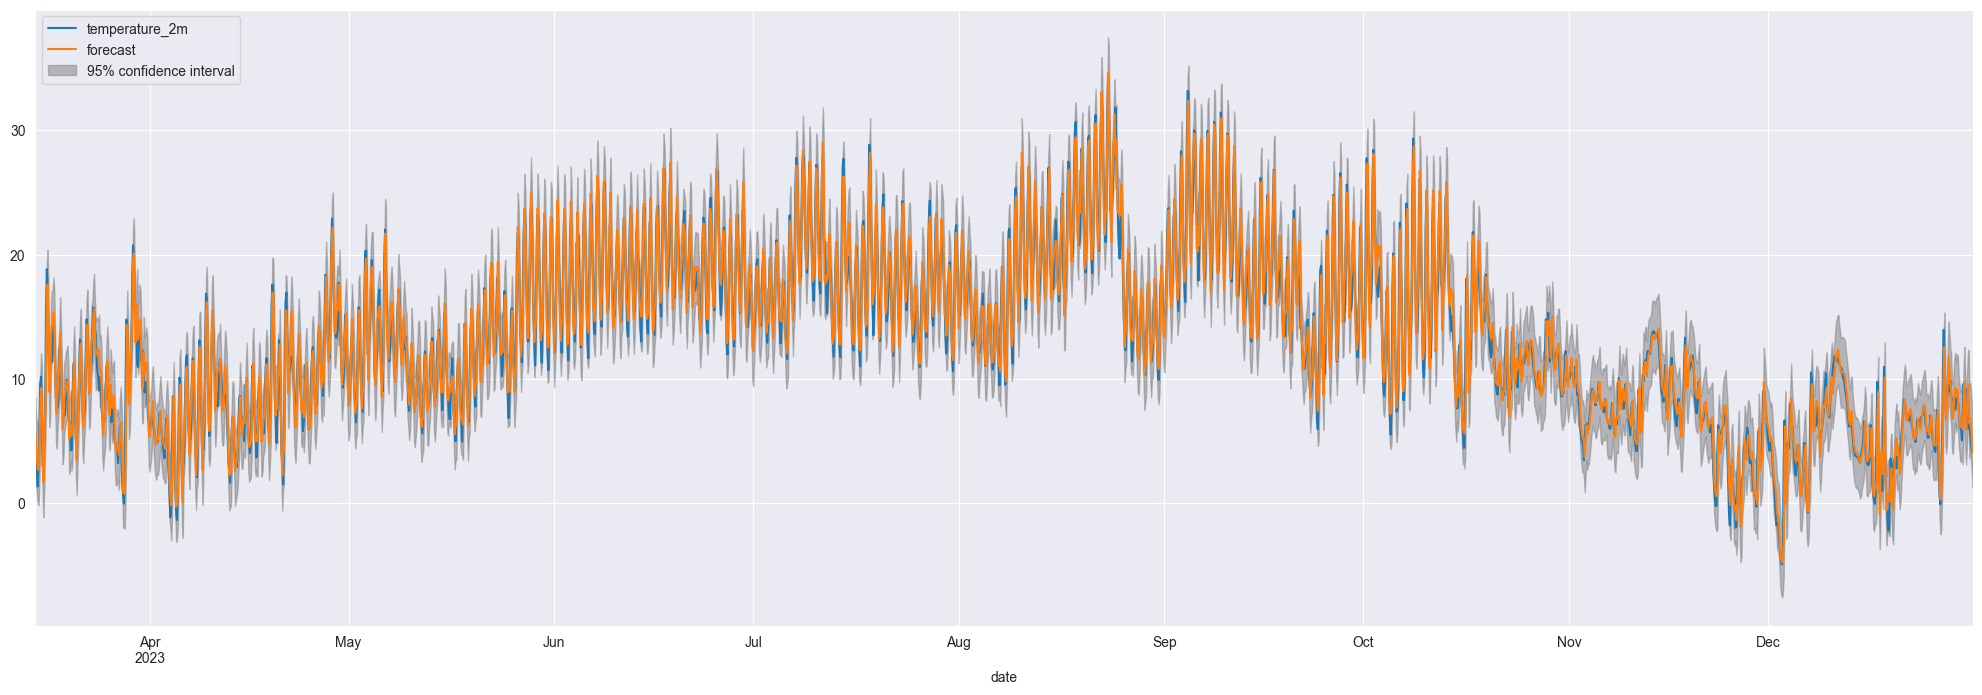

In [76]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots()
ax = ts_test.plot(ax=ax)
fig = plot_predict(model, start=ts_test.index[0], end=ts_test.index[-1], dynamic=False, ax=ax)
legend = ax.legend(loc="upper left")

### Manual params Research SARIMAX Exprimentation

In [77]:
# From PACF plot
p_values = range(0,25)
# From ACF plot
q_values = range(0,25)
# We saw that single differencing transformed the ts into a stationary one
d_values = range(0,1)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

best_order_aic_score, best_order_aic_cfg = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                model = SARIMAX(ts_train, order=order).fit()
                if model.aic < best_order_aic_score:
                    best_order_aic_score, best_order_aic_cfg = model.aic, order
                    print(f'SARIMAX{order} AIC={model.aic:.3f}')
            except:
                continue

print(f'Best SARIMAX{best_order_aic_cfg} AIC={best_order_aic_score:.3f}')

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

best_order_rmse_score, best_order_rmse_cfg = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                model = SARIMAX(ts_train, order=order).fit()
                ts_pred = model.predict(start=ts_test.index[0], end=ts_test.index[-1])
                rmse = mean_squared_error(ts_test.values, ts_pred.values, squared=False)

                if rmse < best_order_rmse_score:
                    best_order_rmse_score, best_order_rmse_cfg = rmse, order
                    print(f'SARIMAX{order} RMSE={rmse:.3f}')
            except:
                continue

print(f'Best SARIMAX{best_order_rmse_cfg} RMSE={best_order_rmse_score:.3f}')

In [78]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

best_order_aic_cfg = (11, 0, 21) 

model_sarimax = SARIMAX(ts_train, order=best_order_aic_cfg).fit()
ts_pred = model_sarimax.predict(start=ts_test.index[0], end=ts_test.index[-1])
rmse = mean_squared_error(ts_test.values, ts_pred.values, squared=False)
print(f'SARIMAX{best_order_aic_cfg}\nAIC={model_sarimax.aic:.2f}\nRMSE (test)={rmse:.2f}')

SARIMAX(11, 0, 21)
AIC=28905.47
RMSE (test)=8.78


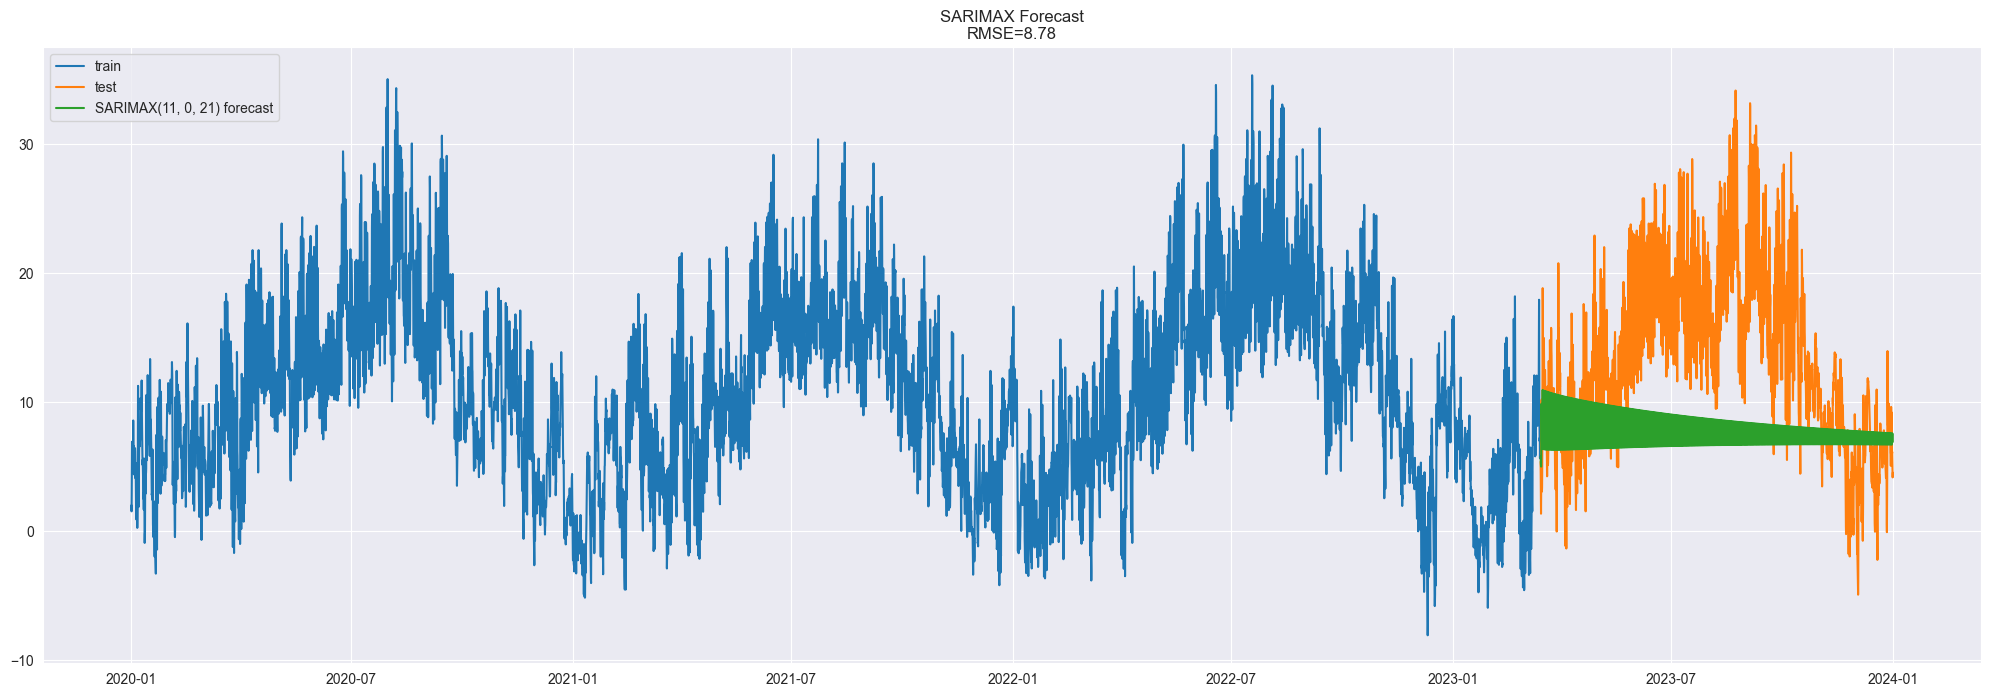

In [79]:
plt.figure()
plt.plot(ts_train.index, ts_train.values, label='train')
plt.plot(ts_test.index, ts_test.values, label='test')
plt.plot(ts_pred.index, ts_pred.values, label=f'SARIMAX{best_order_aic_cfg} forecast')
plt.legend(loc='best')
plt.title(f'SARIMAX Forecast\nRMSE={rmse:.2f}')
plt.show()

### Focusing on auto_arima (from official doc)
The auto_arima function fits the best ARIMA model to a univariate time series according to a provided information criterion (either AIC, AICc, BIC or HQIC). The function performs a search (either stepwise or parallelized) over possible model & seasonal orders within the constraints provided, and selects the parameters that minimize the given metric.
The auto_arima function can be daunting. There are a lot of parameters to tune, and the outcome is heavily dependent on a number of them.
#### For this step we will use directly pmdarima.arima: ARIMA estimator & differencing tests
 pdarima.arima offers :
 * ARIMA auto-parameter selection (we will be using this)
 * ARIMA estimator & statistical tests
 * Under pmdarima we can find datasets, metrics, model_selection, pipeline, preprocessing, utils .ect

In [ ]:
# !pip -q install pmdarima

In [ ]:
# import pmdarima as pm
# #Standard ARIMA Model
# ARIMA_model = pm.auto_arima(ts_data['temperature_2m'],
#                       start_p=1,
#                       start_q=1,
#                       test='adf', # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
#                       d=None,# let model determine 'd'
#                       seasonal=False, # No Seasonality for standard ARIMA
#                       trace=False, #logs
#                       error_action='warn', #shows errors ('ignore' silences these)
#                       suppress_warnings=True,
#                       stepwise=True)

In [ ]:
# dump(ARIMA_model, 'arima_model.joblib')
# loaded_model = load('arima_model.joblib')

**ARIMA(3,0,2)(0,0,0)[0] intercept**

## ML based Exprimentations
**Explanatory variables: lag variables, variables constructed from aggregated values, exogenous variables (you can use the same variable you have chosen for SARIMAX).**

### Lag variables

Code helps to retrive the number of lags to consider

In [ ]:
ml_ts_data = ts_data.copy()
ml_ts_data.head(9)

In [ ]:
# Add columns to the dataframe for lags from 1 to 3
for i in range(1, 4):
    ml_ts_data[f"temperature_2m_lag_{i}"] = ml_ts_data['temperature_2m'].shift(i)

In [80]:
ml_ts_data.head()

,temperature_2m,temperature_2m_lag_1,temperature_2m_lag_2,temperature_2m_lag_3
date,,,,
2020-01-01 09:00:00+00:00,5.579667,2.746333,1.513000,1.979667
2020-01-01 12:00:00+00:00,6.913000,5.579667,2.746333,1.513000
2020-01-01 15:00:00+00:00,5.946333,6.913000,5.579667,2.746333
2020-01-01 18:00:00+00:00,5.296333,5.946333,6.913000,5.579667
2020-01-01 21:00:00+00:00,5.279666,5.296333,5.946333,6.913000


### Drop rows containing NaN

In [81]:
ml_ts_data.dropna(inplace=True)

In [82]:
X = ml_ts_data.drop('temperature_2m', axis=1)
y = ml_ts_data['temperature_2m']

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
X_train.shape, X_test.shape

((9932, 3), (1753, 3))

In [84]:
# Check the chronology
X_train.index.min(), X_train.index.max(), X_test.index.min(), X_test.index.max()

(Timestamp('2020-01-01 09:00:00+0000', tz='UTC'),
 Timestamp('2023-05-26 18:00:00+0000', tz='UTC'),
 Timestamp('2023-05-26 21:00:00+0000', tz='UTC'),
 Timestamp('2023-12-31 21:00:00+0000', tz='UTC'))

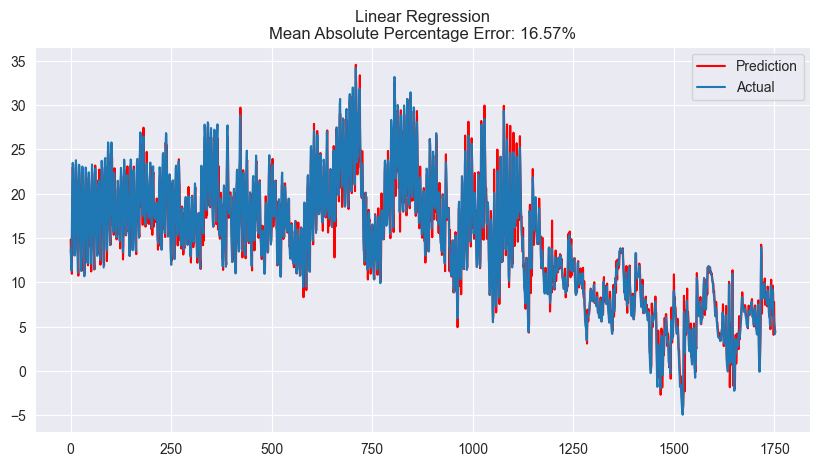

In [85]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
# Calculate error
error = y_test.values - y_pred

# Create a DataFrame with y_pred, y_test, and error
results_df = pd.DataFrame({'Actual': y_test.values, 
                           'Predicted': y_pred, 
                           'Error': error})
plt.figure(figsize=(10, 5))
plt.plot(y_pred, "r", label="Prediction")
plt.plot(y_test.values, label="Actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear Regression\nMean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, y_pred)*100:.2f}%")
plt.show()

In [86]:
ml_ts_data.loc[('2023-05-26 21:00:00+00:00')]

temperature_2m          13.713000
temperature_2m_lag_1    17.479666
temperature_2m_lag_2    21.146334
temperature_2m_lag_3    21.779669
Name: 2023-05-26 21:00:00+00:00, dtype: float32

In [87]:
results_df['X_test'] = (X_test.index)

In [88]:
results_df

,Actual,Predicted,Error,X_test
0,13.713000,14.842242,-1.129242,2023-05-26 21:00:00+00:00
1,12.546333,12.519556,0.026777,2023-05-27 00:00:00+00:00
2,11.329666,13.302098,-1.972432,2023-05-27 03:00:00+00:00
3,15.996333,10.950940,5.045393,2023-05-27 06:00:00+00:00
4,21.579666,19.621544,1.958122,2023-05-27 09:00:00+00:00
...,...,...,...,...
1748,6.129667,4.062785,2.066882,2023-12-31 09:00:00+00:00
1749,5.563000,7.785110,-2.222110,2023-12-31 12:00:00+00:00
1750,4.796333,5.337292,-0.540958,2023-12-31 15:00:00+00:00
1751,4.146333,4.765795,-0.619462,2023-12-31 18:00:00+00:00


### Cv Fit

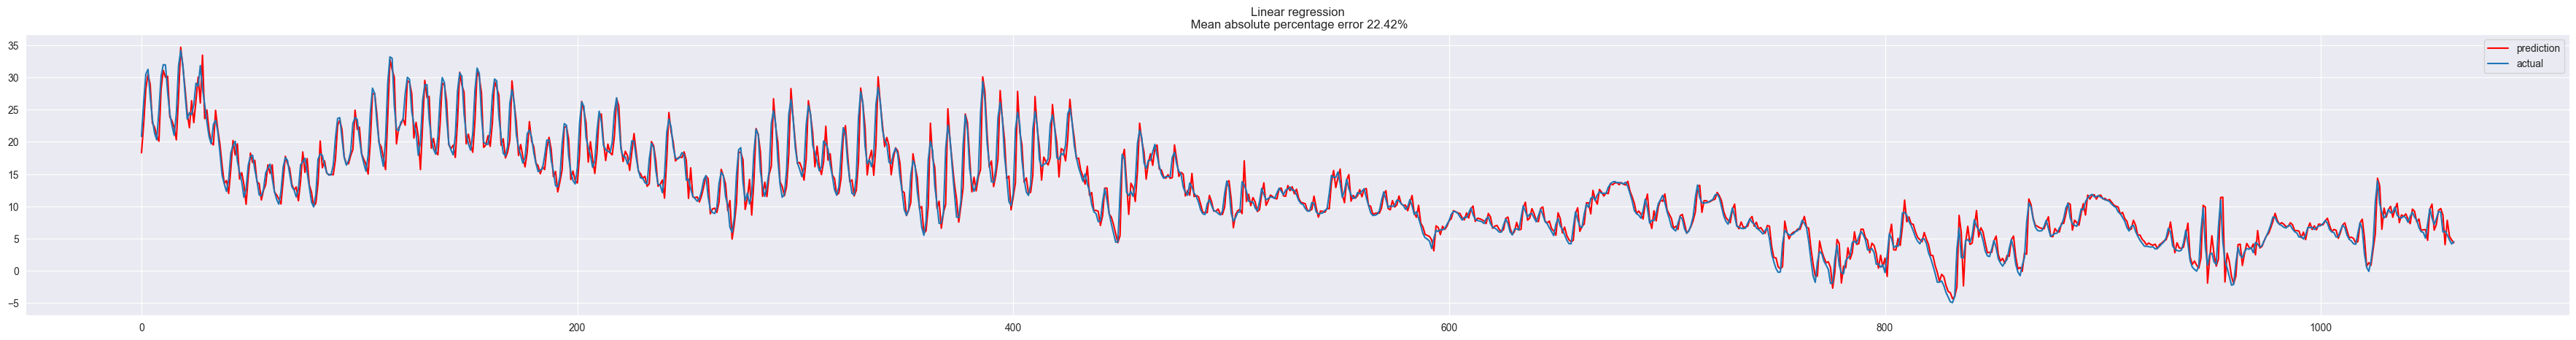

In [89]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

errors = []

tscv = TimeSeriesSplit(n_splits=10)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    errors.append(mean_absolute_percentage_error(y_test, y_pred))
np.mean(errors)

plt.figure(figsize=(45, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute percentage error {mean_absolute_percentage_error(y_test, y_pred)*100:.2f}%");

### Variables constructed from aggregated values

In [90]:
value_column = 'temperature_2m'
# Function that returns a dictionary where:
# the keys correspond to unique values of `cat_feature`, and
# the values correspond to average values of `real_feature`.
def get_mean_by_cat(data, cat_feature, value_feature):
    return dict(data.groupby(cat_feature)[value_feature].mean())

In [91]:
def preprocess_data(data, lag_start=1, lag_end=36, date_cut='31.12.2022'):

    data = pd.DataFrame(data.copy())

    # add time series lags as features
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data[value_column].shift(i)

    # drop NaNs generated by adding lag features
    data = data.dropna()

    data["month"] = data.index.month

    # calculate average values only on train data to avoid data leak
    data["month_average"] = list(map(get_mean_by_cat(data.loc[:date_cut], "month", value_column).get, data.month))

    # drop features that have been used for calculating average values of the target variable
    data.drop(["month"], axis=1, inplace=True)

    # split dataset on train and test parts
    X = data.drop([value_column], axis=1)
    y = data[value_column]
    X_train = X.loc[:date_cut]
    y_train = y.loc[:date_cut]
    X_test = X.loc[date_cut:]
    y_test = y.loc[date_cut:]

    return X_train, X_test, y_train, y_test

In [92]:
ml_ts_data.index.names=['date']
ml_ts_data = ts_data.sort_index()

In [93]:
X_train, X_test, y_train, y_test = preprocess_data(ml_ts_data)

X_train.shape, X_test.shape

((8733, 36), (2928, 36))

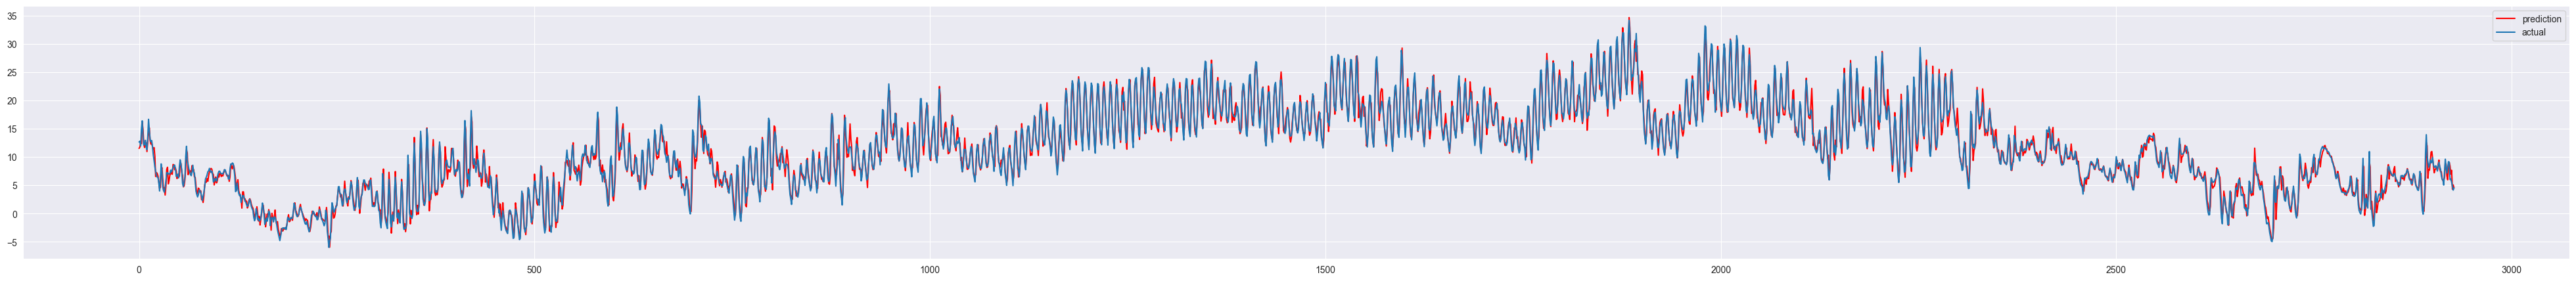

In [94]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(50, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")

## Testing on range 2019 - 2020


In [95]:
test_ts_ds = get_data(begin_date="2019-01-01", end_date="2020-12-31")
test_ts_ds.head(3)

Coordinates 46.01054382324219°N 2.0°E
Elevation 550.0 m asl
Timezone b'Europe/Paris' b'CEST'
Timezone difference to GMT+0 7200 s


,date,temperature_2m
0,2018-12-31 22:00:00+00:00,1.963
1,2018-12-31 23:00:00+00:00,2.013
2,2019-01-01 00:00:00+00:00,2.813


In [96]:
test_ts_ds["date"] = pd.to_datetime(test_ts_ds["date"])
test_ts_ds = test_ts_ds.set_index('date')
test_ts_ds = test_ts_ds.resample('3H').mean()
test_ts_ds.index.names = ['date']
test_ts_ds = test_ts_ds.sort_index()
test_ts_ds

,temperature_2m
date,
2018-12-31 21:00:00+00:00,1.988000
2019-01-01 00:00:00+00:00,2.779667
2019-01-01 03:00:00+00:00,2.829667
2019-01-01 06:00:00+00:00,2.579667
2019-01-01 09:00:00+00:00,3.363000
...,...
2020-12-31 09:00:00+00:00,4.229667
2020-12-31 12:00:00+00:00,4.413000
2020-12-31 15:00:00+00:00,3.013000


In [97]:
X_train, X_test, y_train, y_test = preprocess_data(test_ts_ds,date_cut="2019-12-31")

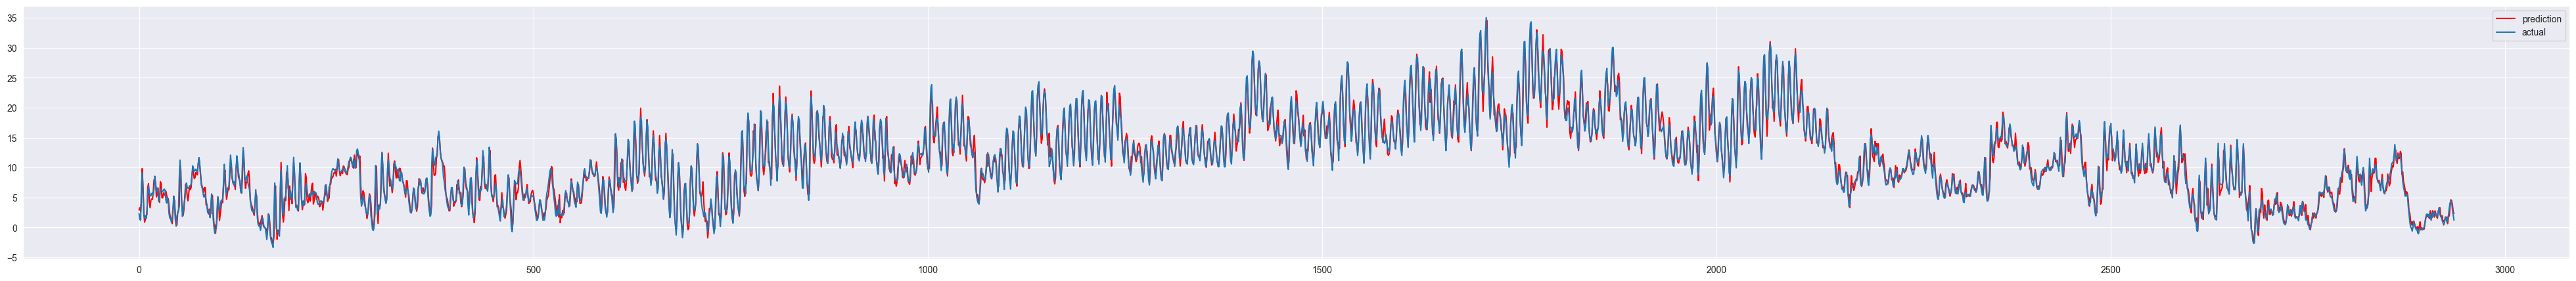

In [98]:
y_pred = lr.predict(X_test)

plt.figure(figsize=(50, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")